In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from tqdm import tqdm
import numpy
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


# load dataset into Pandas DataFrame
df = pd.read_csv("iris.csv")


In [45]:
from sklearn.preprocessing import StandardScaler
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
X = df.loc[:, features].values
x = df.loc[:, features].values
# Separating out the target
Y = df.loc[:,['target']].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

labels_names = ['I.setosa', 'I.versicolor', 'I.virginica']

In [46]:
print(X.shape)

(150, 4)


In [47]:
class KPCA:
    def __init__(self, kernel):
        self.kernel = kernel
        self.X = None
        self.A = None
        self.MV= None
        
    def getNormalise(self, data):
        len= data.shape[0]
        data_1 = numpy.ones((len, len)) / len
        GramMatrix= self.kernel.GramMatrix(data)
        self.MV = numpy.mean(GramMatrix, axis=1) - numpy.mean(GramMatrix)
        return numpy.dot(numpy.dot(numpy.eye(len) - data_1, GramMatrix), numpy.eye(len) - data_1)
    
    def fit(self, data):
        print("Finding !!! ")
        length = data.shape[0]
        self.X = data
        GM = self.getNormalise(data)       
        eig_values, eig_vectors = linalg.eigh(GM)       
        i = range(length)[::-1]
        eig_values = eig_values[i]
        eig_vectors = eig_vectors[:, i]        
        i = eig_values > 0
        eig_values = eig_values[i]
        eig_vectors = eig_vectors[:, i]
        self.A = eig_vectors
        for a, b in enumerate(eig_values):
            self.A[:, a] /= numpy.sqrt(b)
            
    def predict(self, X, cluster=None):
        assert cluster is None or (cluster > 0 and cluster <= self.A.shape[1])
        if cluster is None:
            cluster = self.A.shape[1]

        GM = self.kernel.GramMatrix(X, self.X)
        K = GM - numpy.mean(GM, axis=1)[:, numpy.newaxis] - self.MV
        return numpy.dot(GM, self.A[:, :cluster])
            
        

In [48]:
class Kernel:
    def __init__(self):
        self.name = None

    def calc(self, x, y):
        raise NotImplementedError("Not Done")

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        n = X.shape[0]
        m = Y.shape[0]
        K = numpy.zeros((n, m))

        for i in tqdm(range(n)):
            for j in range(m):
                K[i, j] = self.calc(X[i, :], Y[j, :])
        return K

In [49]:
class PolynomialKernel():
    def __init__(self, degree):
        self.degree = degree
        self.name = 'polynomial_%d' % degree
        
    def calc(self, x, y):
        return (1 + numpy.dot(x, y)) ** self.degree
    
    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        return numpy.dot(X, Y.T) **self.degree

class LinearKernel():
    def __init__(self):
        self.name = 'linear'

    def calc(self, x, y):
        return numpy.dot(x, y)

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        return numpy.dot(X, Y.T)

In [50]:
class GaussianKernel():
    def __init__(self, sigma):
        self.sigma = sigma
        self.name = 'gaussian_%.2f' % sigma

    def calc(self, x, y):
            val=numpy.exp(-numpy.linalg.norm(x - y) ** 2 / (2 * self.sigma ** 2))
            print("Value is"+val)
            return val

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        n = X.shape[0]
        m = Y.shape[0]
        K = numpy.zeros((n, m))

        for i in tqdm(range(m)):
            K[:, i] = numpy.linalg.norm(X - Y[i, :], axis=1) ** 2
        K /= 2 * self.sigma ** 2
        return numpy.exp(-K)

In [51]:
class LaplacianKernel():
    def __init__(self, sigma):
        self.sigma = sigma
        self.name = 'gaussian_%.2f' % sigma

    def calc(self, x, y):
            val=numpy.exp(-numpy.linalg.norm(x - y) *self.sigma)
            print("Value is"+val)
            return val

    def GramMatrix(self, X, Y=None):
        if Y is None:
            Y = X
        n = X.shape[0]
        m = Y.shape[0]
        K = numpy.zeros((n, m))

        for i in tqdm(range(m)):
            K[:, i] = numpy.linalg.norm(X - Y[i, :], axis=1)* self.sigma
       
        return numpy.exp(-K)

In [52]:
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=4)
X_spca = scikit_pca.fit_transform(X)
Components = scikit_pca.fit_transform(X)



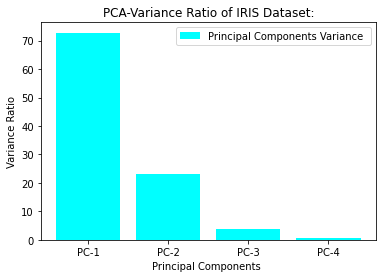

In [53]:
explained_variance = np.var(Components, axis=0)
ev = explained_variance / np.sum(explained_variance)
plt.bar([1,2,3,4],list(ev*100),label='Principal Components Variance ',color='cyan')
plt.legend()
plt.xlabel('Principal Components ')
#----------------------
n=list(ev*100)
pc=[]
for i in range(len(n)):
    n[i]=round(n[i],4)
    pc.append('PC-'+str(i+1))

#----------------------
plt.xticks([1,2,3,4],pc, fontsize=10)
plt.ylabel('Variance Ratio')
plt.title('PCA-Variance Ratio of IRIS Dataset:')
plt.show()

In [54]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
Components = scikit_pca.fit_transform(X)

principalDf = pd.DataFrame(data = Components
                 , columns = ['PC-1', 'PC-2'])

print(X_spca.shape)

(150, 2)


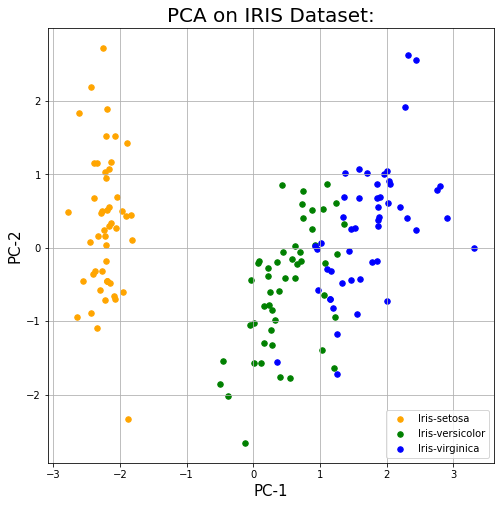

In [55]:
 # Adding lables
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
# Plotting pc1 & pc2
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC-1', fontsize = 15)
ax.set_ylabel('PC-2', fontsize = 15)
ax.set_title('PCA on IRIS Dataset:', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['orange', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC-1'], finalDf.loc[indicesToKeep, 'PC-2'], c = color, s = 30)
ax.legend(targets)
ax.grid()
plt.show()

In [56]:
# splitting testing ab=nd training data
from sklearn.svm import SVC
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(X_spca, Y, test_size=0.4, random_state=33)

# training the SVM classifier
clf=SVC()
clf.fit(x_train_pca, y_train_pca)

# predicting the results
pred_pca_SVC = clf.predict(x_test_pca)

# generate evaluation report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\nClasification report:\n', classification_report(y_test_pca, pred_pca_SVC))
print ('\nConfussion matrix:\n',confusion_matrix(y_test_pca, pred_pca_SVC))


Clasification report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        17
Iris-versicolor       0.74      1.00      0.85        20
 Iris-virginica       1.00      0.70      0.82        23

       accuracy                           0.88        60
      macro avg       0.91      0.90      0.89        60
   weighted avg       0.91      0.88      0.88        60


Confussion matrix:
 [[17  0  0]
 [ 0 20  0]
 [ 0  7 16]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [57]:
#Applying Kernel PCA 
#Linear Kernel :
#umber of components =2 
kpca = KPCA(LinearKernel())
X_kpca=kpca.fit(X)
X_kpca1 = kpca.predict(X,2)
Components = kpca.predict(X,2)
principalDf = pd.DataFrame(data = Components
                 , columns = ['PC-1', 'PC-2'])
print(X_kpca1.shape)


Finding !!! 
(150, 2)


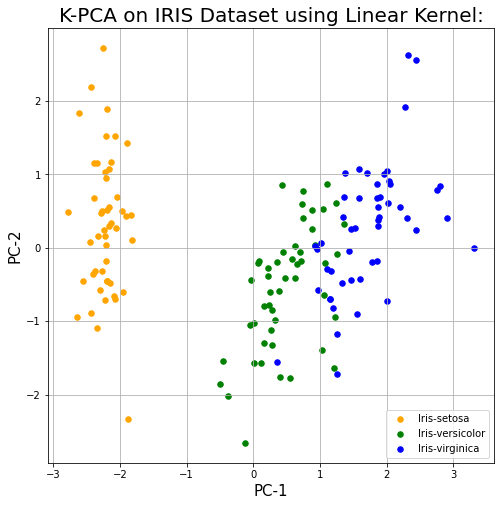

In [58]:
 # Adding lables
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
# Plotting pc1 & pc2
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC-1', fontsize = 15)
ax.set_ylabel('PC-2', fontsize = 15)
ax.set_title('K-PCA on IRIS Dataset using Linear Kernel:', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['orange', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC-1'], finalDf.loc[indicesToKeep, 'PC-2'], c = color, s = 30)
ax.legend(targets)
ax.grid()
plt.show()

In [59]:
# splitting testing ab=nd training data
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X_kpca1, Y, test_size=0.4, random_state=33)

# training the SVM classifier
clf=SVC()
clf.fit(x_train, y_train)

# predicting the results
pred = clf.predict(x_test)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [60]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\nClasification report:\n', classification_report(y_test, pred))
print ('\nConfussion matrix:\n',confusion_matrix(y_test, pred))


Clasification report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        17
Iris-versicolor       0.74      1.00      0.85        20
 Iris-virginica       1.00      0.70      0.82        23

       accuracy                           0.88        60
      macro avg       0.91      0.90      0.89        60
   weighted avg       0.91      0.88      0.88        60


Confussion matrix:
 [[17  0  0]
 [ 0 20  0]
 [ 0  7 16]]


100%|█████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 24999.83it/s]

Finding !!! 


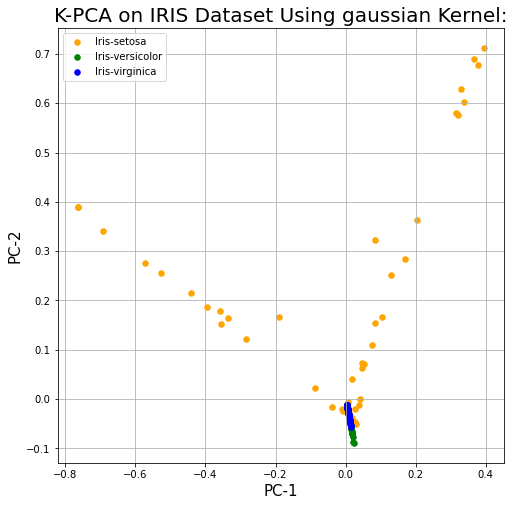

In [61]:
#Applying Kernel PCA 
#Guassian Kernel :
#umber of components =2 and Gamma=1
kpca = KPCA(GaussianKernel(0.2))
X_kpca=kpca.fit(X)
X_kpca1 = kpca.predict(X,2)
Components = kpca.predict(X,2)
principalDf = pd.DataFrame(data = Components
                 , columns = ['PC-1', 'PC-2'])



 # Adding lables
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
# Plotting pc1 & pc2
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC-1', fontsize = 15)
ax.set_ylabel('PC-2', fontsize = 15)
ax.set_title('K-PCA on IRIS Dataset Using gaussian Kernel:', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['orange', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC-1'], finalDf.loc[indicesToKeep, 'PC-2'], c = color, s = 30)
ax.legend(targets)
ax.grid()
plt.show()

In [62]:
# splitting testing ab=nd training data
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X_kpca1, Y, test_size=0.4, random_state=33)

# training the SVM classifier
clf=SVC()
clf.fit(x_train, y_train)

# predicting the results
pred = clf.predict(x_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\nClasification report:\n', classification_report(y_test, pred))
print ('\nConfussion matrix:\n',confusion_matrix(y_test, pred))


Clasification report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      0.65      0.79        17
Iris-versicolor       0.42      1.00      0.59        20
 Iris-virginica       0.00      0.00      0.00        23

       accuracy                           0.52        60
      macro avg       0.47      0.55      0.46        60
   weighted avg       0.42      0.52      0.42        60


Confussion matrix:
 [[11  5  1]
 [ 0 20  0]
 [ 0 23  0]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [63]:
#Applying Kernel PCA 
#Poly Kernel :
#umber of components =2,degree=3 
kpca = KPCA(PolynomialKernel(3))
X_kpca=kpca.fit(X)
X_kpca1 = kpca.predict(X,2)
Components = kpca.predict(X,2)
principalDf = pd.DataFrame(data = Components
                 , columns = ['PC-1', 'PC-2'])
print(X_kpca1.shape)

Finding !!! 
(150, 2)


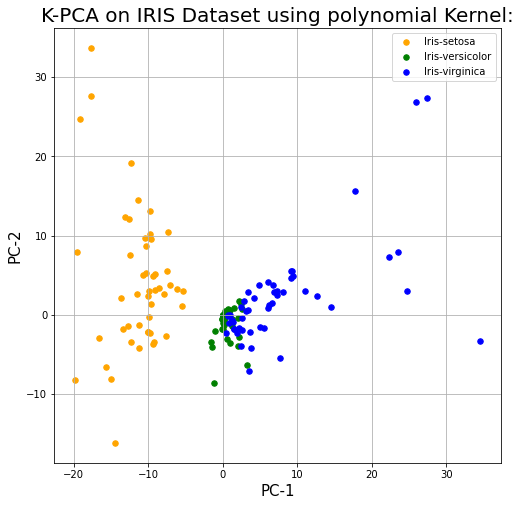

In [64]:
# Adding lables
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
# Plotting pc1 & pc2
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC-1', fontsize = 15)
ax.set_ylabel('PC-2', fontsize = 15)
ax.set_title('K-PCA on IRIS Dataset using polynomial Kernel:', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['orange', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC-1'], finalDf.loc[indicesToKeep, 'PC-2'], c = color, s = 30)
ax.legend(targets)
ax.grid()
plt.show()

In [65]:
# splitting testing ab=nd training data
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X_kpca1, Y, test_size=0.4, random_state=33)

# training the SVM classifier
clf=SVC()
clf.fit(x_train, y_train)

# predicting the results
pred = clf.predict(x_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\nClasification report:\n', classification_report(y_test, pred))
print ('\nConfussion matrix:\n',confusion_matrix(y_test, pred))


Clasification report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        17
Iris-versicolor       0.67      1.00      0.80        20
 Iris-virginica       1.00      0.57      0.72        23

       accuracy                           0.83        60
      macro avg       0.89      0.86      0.84        60
   weighted avg       0.89      0.83      0.83        60


Confussion matrix:
 [[17  0  0]
 [ 0 20  0]
 [ 0 10 13]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [66]:
#Applying Kernel PCA 
#Laplacian Kernel :
#umber of components =2,gamma=10 
kpca = KPCA(LaplacianKernel(5))
X_kpca=kpca.fit(X)
X_kpca1 = kpca.predict(X,2)
Components = kpca.predict(X,2)
axes = pd.DataFrame(data = Components
                 , columns = ['PC-1', 'PC-2'])
print(X_kpca1.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 75032.27it/s]

Finding !!! 
(150, 2)


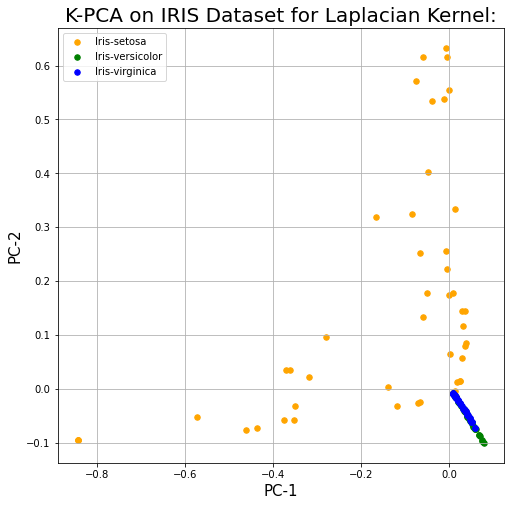

In [67]:
# Adding lables
finalDf = pd.concat([axes, df[['target']]], axis = 1)
# Plotting pc1 & pc2
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC-1', fontsize = 15)
ax.set_ylabel('PC-2', fontsize = 15)
ax.set_title('K-PCA on IRIS Dataset for Laplacian Kernel:', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['orange', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC-1'], finalDf.loc[indicesToKeep, 'PC-2'], c = color, s = 30)
ax.legend(targets)
ax.grid()
plt.show()

In [68]:
# splitting testing ab=nd training data
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(X_kpca1, Y, test_size=0.4, random_state=33)

# training the SVM classifier
clf=SVC()
clf.fit(x_train, y_train)

# predicting the results
pred = clf.predict(x_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print('\nClasification report:\n', classification_report(y_test, pred))
print ('\nConfussion matrix:\n',confusion_matrix(y_test, pred))


Clasification report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      0.82      0.90        17
Iris-versicolor       0.52      0.70      0.60        20
 Iris-virginica       0.53      0.43      0.48        23

       accuracy                           0.63        60
      macro avg       0.68      0.65      0.66        60
   weighted avg       0.66      0.63      0.64        60


Confussion matrix:
 [[14  0  3]
 [ 0 14  6]
 [ 0 13 10]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
